In [1]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (3783/3783), done.


The dataset contains:

* 10 clothing categories (dress, hat, longsleeve, outwear, pants, shirt, shoes, shorts, skirt, t-shirt)
* Training, validation, and test splits
* Pre-organized directory structure

In [2]:
import torch

In [3]:
from PIL import Image
import numpy as np

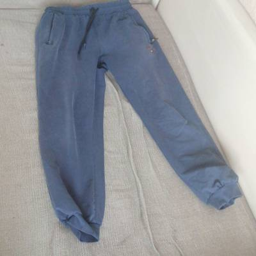

In [9]:
# Load an image


img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img.resize((256, 256))

In [12]:
# Resize to target size

X = np.array(img.resize((224, 224)))

In [14]:
print(X.shape)  # (224, 224, 3)

(224, 224, 3)


In [6]:
import torchvision.models as models
from torchvision import transforms

In [7]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval(); # using the model for evaluation only

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


In [15]:
# Defining some Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Now do the prediction:



In [16]:
x = preprocess(img)

batch_t = torch.unsqueeze(x, 0)

with torch.no_grad():
    output = model(batch_t)

_, indices = torch.sort(output, descending=True)

Let's see what's inside:

In [17]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2025-12-05 11:32:44--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-12-05 11:32:45 (87.8 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
indices

In [19]:
# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


## Transfer Learning


Transfer Learning reuses a model trained on one task (ImageNet) for a different task (clothing classification).

Approach:

* Load pre-trained model (feature extractor)
* Remove original classification head
* Freeze convolutional layers
* Add custom layers for our task
* Train only the new layers


**Custom Dataset Class**

First, create a PyTorch Dataset to load images:

In [20]:
import os
from torch.utils.data import Dataset
from PIL import Image

class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

This code defines a custom PyTorch Dataset class called ClothingDataset. This class is essential for loading and managing your image data for training a machine learning model, especially when using PyTorch's data loaders. Here's a breakdown:

__init__(self, data_dir, transform=None): This is the constructor. It takes the data_dir (the path to your dataset) and an optional transform function. It scans the data_dir to find all image paths and their corresponding labels, storing them in self.image_paths and self.labels. It also creates a mapping from class names to integer indices (self.class_to_idx).

__len__(self): This method returns the total number of samples (images) in the dataset, which is the length of self.image_paths.

__getitem__(self, idx): This is the core method for retrieving a single item. Given an index idx, it loads the image from self.image_paths[idx], converts it to RGB, applies any specified transform (like resizing or normalization), and returns the processed image along with its numerical label (self.labels[idx]).

In summary, this class provides a standardized way to access your clothing dataset images and their labels, making it compatible with PyTorch's data loading utilities for trainin

## Simple Preprocessing


In [22]:
from torchvision import transforms

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Create Loaders

In [23]:
from torch.utils.data import DataLoader

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Build the Model


In [24]:
import torch.nn as nn
import torchvision.models as models

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

## Train the Model


In [25]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

## Now train it:



In [26]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/10
  Train Loss: 1.4795, Train Acc: 0.6281
  Val Loss: 0.7258, Val Acc: 0.7595
Epoch 2/10
  Train Loss: 0.7618, Train Acc: 0.7656
  Val Loss: 1.1479, Val Acc: 0.6774
Epoch 3/10
  Train Loss: 0.7372, Train Acc: 0.7907
  Val Loss: 1.2807, Val Acc: 0.6716
Epoch 4/10
  Train Loss: 0.6507, Train Acc: 0.8083
  Val Loss: 0.9919, Val Acc: 0.7331
Epoch 5/10
  Train Loss: 0.5959, Train Acc: 0.8253
  Val Loss: 1.2371, Val Acc: 0.7361
Epoch 6/10
  Train Loss: 0.5774, Train Acc: 0.8360
  Val Loss: 1.4123, Val Acc: 0.6950
Epoch 7/10
  Train Loss: 0.5919, Train Acc: 0.8390
  Val Loss: 1.1651, Val Acc: 0.7331
Epoch 8/10
  Train Loss: 0.5762, Train Acc: 0.8419
  Val Loss: 1.5142, Val Acc: 0.7361
Epoch 9/10
  Train Loss: 0.4473, Train Acc: 0.8693
  Val Loss: 1.0861, Val Acc: 0.7566
Epoch 10/10
  Train Loss: 0.5164, Train Acc: 0.8638
  Val Loss: 1.0122, Val Acc: 0.7625


**Based on the training output, the best validation accuracy achieved was 0.7625 (or 76.25%) in Epoch 10**

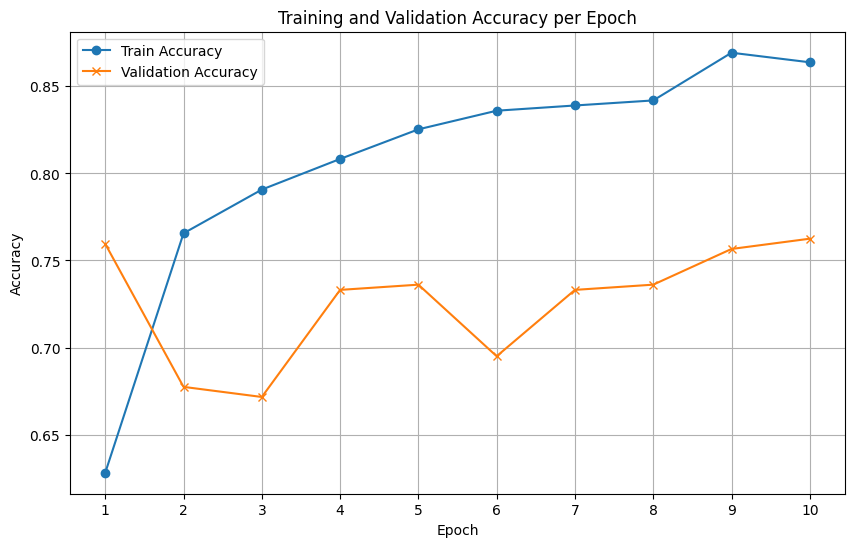

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, 11) # From 1 to 10 epochs
train_accuracies = [0.6281, 0.7656, 0.7907, 0.8083, 0.8253, 0.8360, 0.8390, 0.8419, 0.8693, 0.8638]
val_accuracies = [0.7595, 0.6774, 0.6716, 0.7331, 0.7361, 0.6950, 0.7331, 0.7361, 0.7566, 0.7625]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='x')

plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs) # Ensure all epochs are marked on the x-axis
plt.grid(True)
plt.legend()
plt.show()

It's a lower-level framework, that's why we need to implement some of these things like calculating accuracy on validation.

The line `optimizer.zero_grad()` is crucial in the training loop.

In PyTorch, gradients are accumulated by default. This means that if you don't zero the gradients before calculating the gradients for the current batch, the gradients from the previous batch will be added to the gradients of the current batch. This would lead to incorrect updates to your model's parameters.

By calling `optimizer.zero_grad()`, you clear out the old gradients, ensuring that the gradients calculated during the `loss.backward()` call are only based on the current batch of data. This is essential for the optimizer to take the correct step during `optimizer.step()`.

`model.train()` and `model.eval()` are needed to manage the behavior of certain layers during training and evaluation.

`model.train()` sets the model to training mode. In training mode, layers like Dropout and BatchNorm behave differently. Dropout layers are active (randomly dropping neurons), and `BatchNorm` layers update their running statistics (mean and variance) based on the current batch.

`model.eval()` sets the model to evaluation mode. In evaluation mode, Dropout layers are inactive (they pass through all neurons), and BatchNorm layers use their accumulated running statistics instead of the current batch statistics. This ensures consistent behavior during inference and prevents randomness from affecting the evaluation results.

Let's put it inside a function so it's easier for us to call it:

In [27]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

## 6. Tuning the Learning Rate


The learning rate controls how much to update model weights during training. It's one of the most important hyperparameters.

`Analogy: Reading speed`

* Too fast: Skip details, poor understanding (may not converge)
* Too slow: Never finish the book (training takes too long)
* Just right: Good comprehension and efficiency
* Experimentation approach:

Try multiple values: [0.0001, 0.001, 0.01, 0.1]
* Train for a few epochs each
* Compare validation accuracy
* Choose the rate with best performance and smallest train/val gap`

In [29]:
def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

Let's test different learning rates:



In [30]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Learning Rate: 0.0001 ===
Epoch 1/10
  Train Loss: 2.0266, Train Acc: 0.2881
  Val Loss: 1.7782, Val Acc: 0.4487
Epoch 2/10
  Train Loss: 1.6537, Train Acc: 0.4847
  Val Loss: 1.5025, Val Acc: 0.5660
Epoch 3/10
  Train Loss: 1.4145, Train Acc: 0.5834
  Val Loss: 1.3023, Val Acc: 0.6100
Epoch 4/10
  Train Loss: 1.2541, Train Acc: 0.6353
  Val Loss: 1.1744, Val Acc: 0.6657
Epoch 5/10
  Train Loss: 1.1398, Train Acc: 0.6816
  Val Loss: 1.0695, Val Acc: 0.6979
Epoch 6/10
  Train Loss: 1.0437, Train Acc: 0.7063
  Val Loss: 0.9974, Val Acc: 0.7331
Epoch 7/10
  Train Loss: 0.9747, Train Acc: 0.7304
  Val Loss: 0.9308, Val Acc: 0.7566
Epoch 8/10
  Train Loss: 0.9315, Train Acc: 0.7464
  Val Loss: 0.8847, Val Acc: 0.7361
Epoch 9/10
  Train Loss: 0.8675, Train Acc: 0.7591
  Val Loss: 0.8470, Val Acc: 0.7595
Epoch 10/10
  Train Loss: 0.8276, Train Acc: 0.7702
  Val Loss: 0.8182, Val Acc: 0.7654

=== Learning Rate: 0.001 ===
Epoch 1/10
  Train Loss: 1.3374, Train Acc: 0.5756
  Val Loss: 0.847

**The best learning rate is 0.001 (accuracy 0.815).**

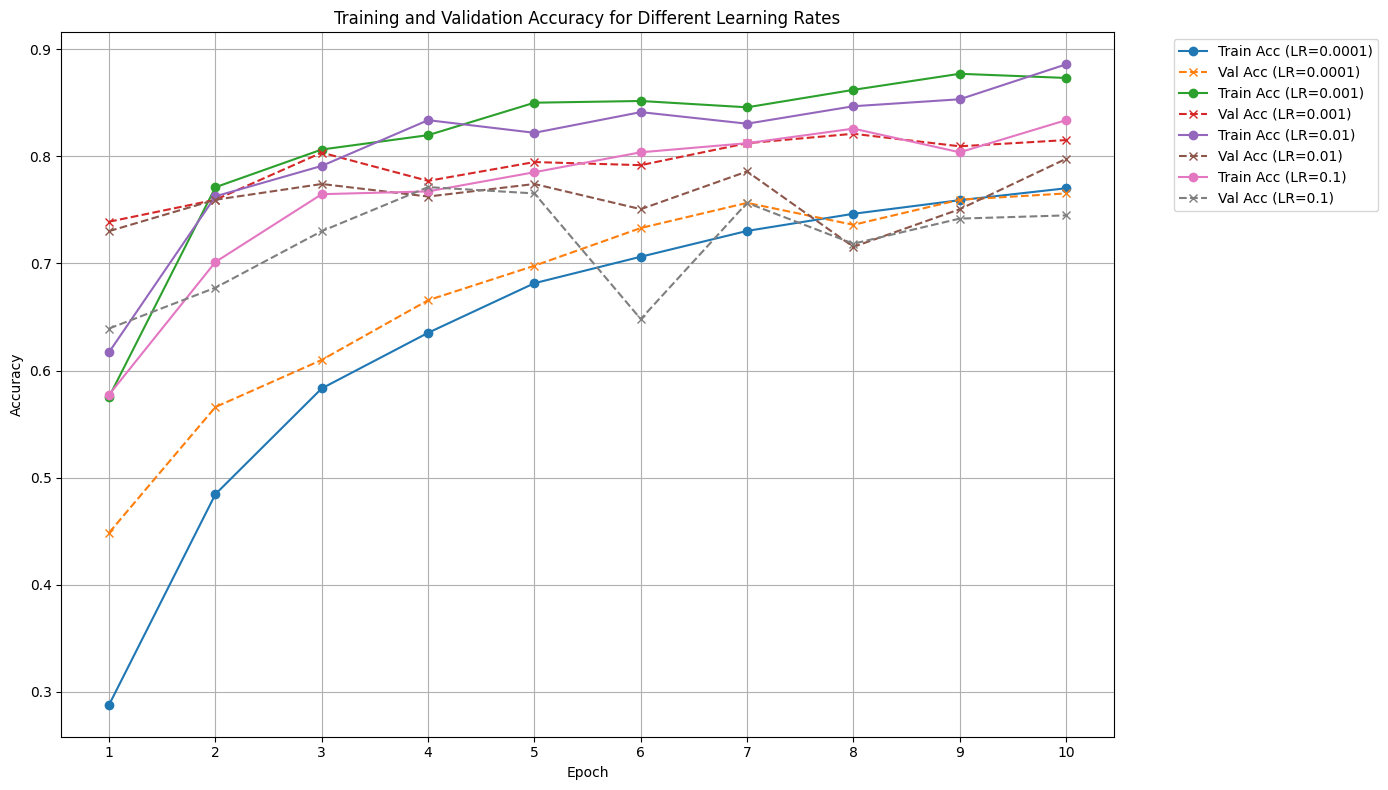

In [31]:
import matplotlib.pyplot as plt

# Data extracted from the previous execution output
learning_rates_data = {
    0.0001: {
        "train_acc": [0.2881, 0.4847, 0.5834, 0.6353, 0.6816, 0.7063, 0.7304, 0.7464, 0.7591, 0.7702],
        "val_acc": [0.4487, 0.5660, 0.6100, 0.6657, 0.6979, 0.7331, 0.7566, 0.7361, 0.7595, 0.7654]
    },
    0.001: {
        "train_acc": [0.5756, 0.7712, 0.8064, 0.8198, 0.8501, 0.8517, 0.8458, 0.8621, 0.8771, 0.8732],
        "val_acc": [0.7390, 0.7595, 0.8035, 0.7771, 0.7947, 0.7918, 0.8123, 0.8211, 0.8094, 0.8152]
    },
    0.01: {
        "train_acc": [0.6173, 0.7627, 0.7911, 0.8338, 0.8220, 0.8413, 0.8305, 0.8468, 0.8533, 0.8859],
        "val_acc": [0.7302, 0.7595, 0.7742, 0.7625, 0.7742, 0.7507, 0.7859, 0.7155, 0.7507, 0.7977]
    },
    0.1: {
        "train_acc": [0.5776, 0.7014, 0.7647, 0.7673, 0.7852, 0.8038, 0.8123, 0.8259, 0.8038, 0.8338],
        "val_acc": [0.6393, 0.6774, 0.7302, 0.7713, 0.7654, 0.6481, 0.7566, 0.7185, 0.7419, 0.7449]
    }
}

epochs = range(1, 11)

plt.figure(figsize=(14, 8))

for lr, data in learning_rates_data.items():
    plt.plot(epochs, data["train_acc"], marker='o', label=f'Train Acc (LR={lr})')
    plt.plot(epochs, data["val_acc"], marker='x', linestyle='--', label=f'Val Acc (LR={lr})')

plt.title('Training and Validation Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.tight_layout()
plt.show()

From the plot, the learning rate of `0.001` appears to be the best performing. It consistently shows high validation accuracy, reaching over `80%`, and a relatively stable training process compared to the other learning rates.

* A learning rate of `0.0001` was `too slow`, leading to slower convergence and lower overall accuracy.
* Learning rates of `0.01` and `0.1` show more volatile behavior, especially the 0.1 learning rate, which exhibits significant fluctuations in both training and validation accuracy, indicating it might be too aggressive and skipping optimal solutions or even diverging.

## 7. Model Checkpointing

Checkpointing saves the model during training to:

* Keep the best performing model
* Resume training if interrupted
* Avoid losing progress


Update the train function:

In [32]:
def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy

    # exising code
    # Checkpoint the model if validation accuracy improved
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        checkpoint_path = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')

In [33]:
for lr in [0.001, 0.1]: #0.01, 0.1]:
  print("learning rate =", lr)
  model, optimizer = make_model(lr)
  train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

learning rate = 0.001
Epoch 1/10
  Train Loss: 1.2932, Train Acc: 0.5997
  Val Loss: 0.8544, Val Acc: 0.7595
Epoch 2/10
  Train Loss: 0.7478, Train Acc: 0.7656
  Val Loss: 0.6639, Val Acc: 0.7977
Epoch 3/10
  Train Loss: 0.6162, Train Acc: 0.8080
  Val Loss: 0.6019, Val Acc: 0.7947
Epoch 4/10
  Train Loss: 0.5438, Train Acc: 0.8312
  Val Loss: 0.5666, Val Acc: 0.8035
Epoch 5/10
  Train Loss: 0.5024, Train Acc: 0.8396
  Val Loss: 0.5764, Val Acc: 0.8006
Epoch 6/10
  Train Loss: 0.4608, Train Acc: 0.8553
  Val Loss: 0.5462, Val Acc: 0.8123
Epoch 7/10
  Train Loss: 0.4365, Train Acc: 0.8654
  Val Loss: 0.5733, Val Acc: 0.8123
Epoch 8/10
  Train Loss: 0.4212, Train Acc: 0.8628
  Val Loss: 0.5435, Val Acc: 0.8123
Epoch 9/10
  Train Loss: 0.4027, Train Acc: 0.8709
  Val Loss: 0.5584, Val Acc: 0.8006
Epoch 10/10
  Train Loss: 0.3711, Train Acc: 0.8778
  Val Loss: 0.5613, Val Acc: 0.8065
learning rate = 0.1
Epoch 1/10
  Train Loss: 12.6860, Train Acc: 0.5828
  Val Loss: 5.3394, Val Acc: 0.7273

The learning rate of `0.001` was observed to be behaving the best, demonstrating the highest validation accuracy and a more stable training process.

 Here is a plot highlighting its performance:

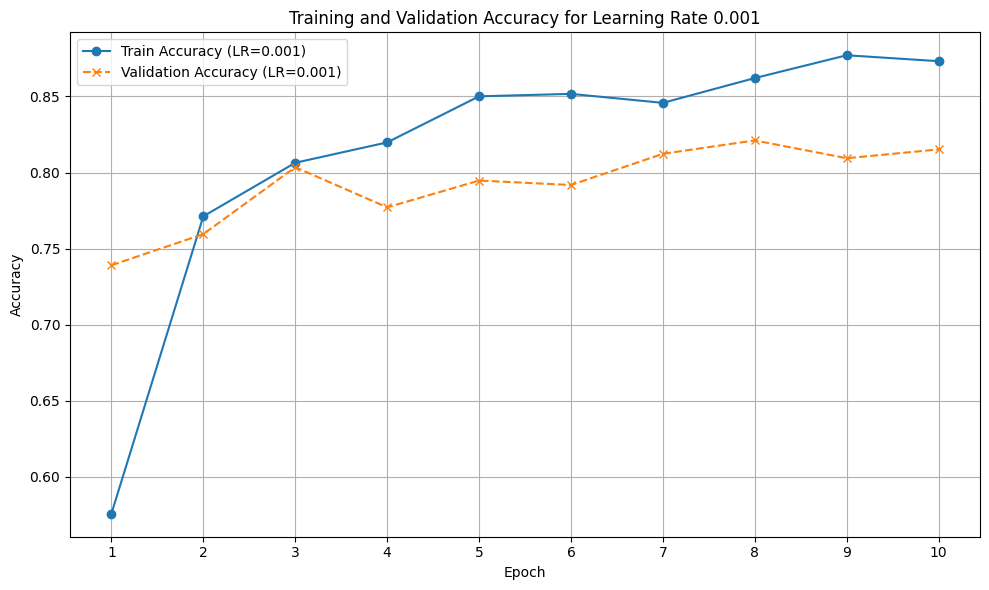

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

# Data for the best performing learning rate (0.001)
best_lr_data = {
    "train_acc": [0.5756, 0.7712, 0.8064, 0.8198, 0.8501, 0.8517, 0.8458, 0.8621, 0.8771, 0.8732],
    "val_acc": [0.7390, 0.7595, 0.8035, 0.7771, 0.7947, 0.7918, 0.8123, 0.8211, 0.8094, 0.8152]
}

plt.figure(figsize=(10, 6))
plt.plot(epochs, best_lr_data["train_acc"], marker='o', label='Train Accuracy (LR=0.001)')
plt.plot(epochs, best_lr_data["val_acc"], marker='x', linestyle='--', label='Validation Accuracy (LR=0.001)')

plt.title('Training and Validation Accuracy for Learning Rate 0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

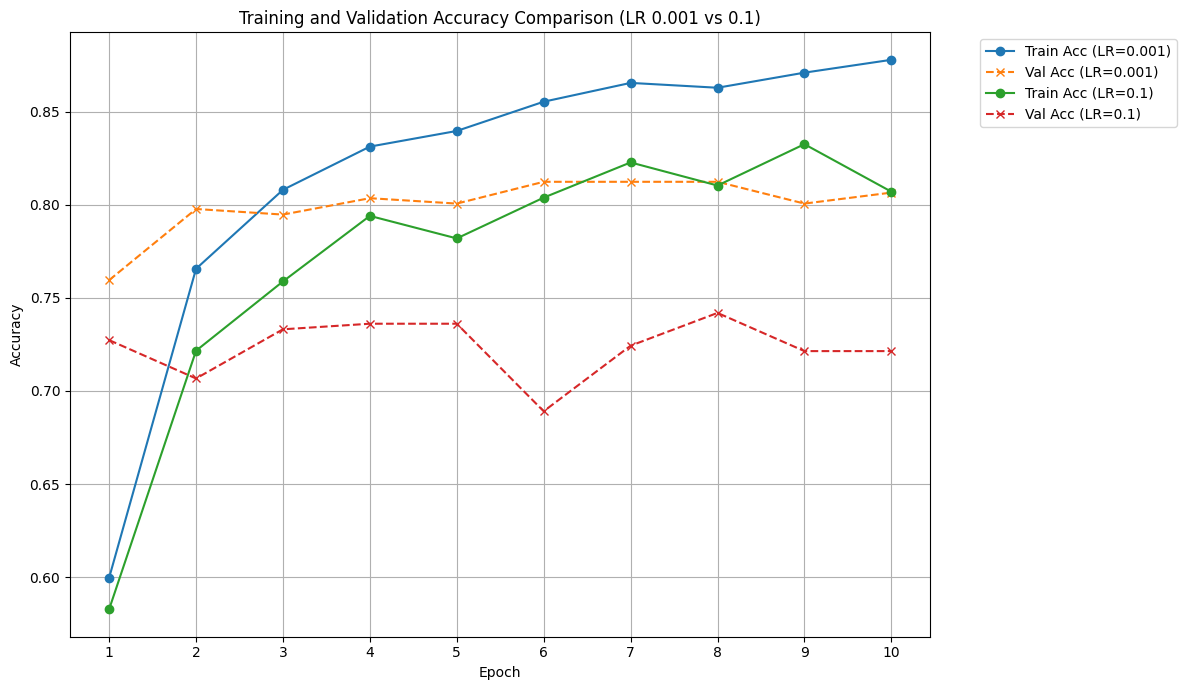

In [35]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

# Data for learning rate 0.001 (from latest run)
lr_001_data = {
    "train_acc": [0.5997, 0.7656, 0.8080, 0.8312, 0.8396, 0.8553, 0.8654, 0.8628, 0.8709, 0.8778],
    "val_acc": [0.7595, 0.7977, 0.7947, 0.8035, 0.8006, 0.8123, 0.8123, 0.8123, 0.8006, 0.8065]
}

# Data for learning rate 0.1 (from latest run)
lr_01_data = {
    "train_acc": [0.5828, 0.7216, 0.7588, 0.7940, 0.7819, 0.8038, 0.8227, 0.8103, 0.8325, 0.8070],
    "val_acc": [0.7273, 0.7067, 0.7331, 0.7361, 0.7361, 0.6891, 0.7243, 0.7419, 0.7214, 0.7214]
}

plt.figure(figsize=(12, 7))

# Plot for LR 0.001
plt.plot(epochs, lr_001_data["train_acc"], marker='o', label='Train Acc (LR=0.001)')
plt.plot(epochs, lr_001_data["val_acc"], marker='x', linestyle='--', label='Val Acc (LR=0.001)')

# Plot for LR 0.1
plt.plot(epochs, lr_01_data["train_acc"], marker='o', label='Train Acc (LR=0.1)')
plt.plot(epochs, lr_01_data["val_acc"], marker='x', linestyle='--', label='Val Acc (LR=0.1)')

plt.title('Training and Validation Accuracy Comparison (LR 0.001 vs 0.1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.tight_layout()
plt.show()

TensorFlow/Keras equivalent:

* Keras: `ModelCheckpoint` callback
* PyTorch: Manual saving in training loop

## 8. Adding Inner Layers

We can add intermediate dense layers between feature extraction and output:



In [36]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

Update `make_model`:



In [37]:
def make_model(learning_rate=0.001, size_inner=100):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

Experiment with different sizes:


*   Try: size_inner = [10, 100, 1000]
*   Larger layers: more capacity, may overfit
*   Smaller layers: faster, may underfit


Key points:

1.   Inner layer uses ReLU activation
2.   Output layer has no activation (logits)
3.   CrossEntropyLoss applies softmax internally

## 9. Regularization: Dropout

**Dropout** randomly drops neurons during **training** to prevent **overfitting**.

How it works:

* Training: randomly set fraction of activations to 0
* Inference: use all neurons (dropout disabled automatically)
* Creates ensemble effect

Benefits:

* Prevents relying on specific features
* Forces learning robust patterns
* Reduces overfitting

In [38]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

* Update our function:

In [39]:
def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.2 # it is the percent of the weight we droppped
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

Experimentation:

Try: `droprate = [0.0, 0.2, 0.5, 0.8]`

Typical values: `0.2 to 0.5`

Higher dropout may need more training epochs


(Our case: best droprate is `0.2`)

## 10. Data Augmentation


Data Augmentation artificially increases dataset size by applying random transformations to training images.


Common transformations:


* Rotation
* Horizontal/vertical flipping
* Zooming (random cropping)
* Shifting
* Shearing


Important rules:

* ✅ Apply ONLY to training data
* ❌ Never augment validation/test data

**Augmented Training Transforms**

In [40]:
# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as before
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

When to use augmentation:

* Small datasets
* Risk of overfitting
* Images can appear in different orientations


Tips:

* Choose augmentations that make sense for your data
* Too much augmentation can hurt performance
* Usually requires longer training (more epochs)
* If no improvement after ~20 epochs, don't use it

## 11. Using the Trained Model


Loading a Saved Model


Making Predictions


In [44]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'clothing_v4_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [49]:
# Import trained model
import glob

# Find best checkpoint
list_of_files = glob.glob('clothing_v4_*.pth')
latest_file = max(list_of_files, key=os.path.getctime)
print(f"Loading model from: {latest_file}")

# Load model
model = ClothingClassifierMobileNet(size_inner=100, droprate=0.2, num_classes=10)
model.load_state_dict(torch.load(latest_file))
model.to(device)

Loading model from: clothing_v4_04_0.821.pth


ClothingClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

In [45]:
import torch.nn as nn

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x


def make_model(
        learning_rate=0.01,
        size_inner=100,
        droprate=0.2,
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate,
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [46]:
num_epochs = 50

model, optimizer = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.2,
)

train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/50
  Train Loss: 1.3749, Train Acc: 0.5440
  Val Loss: 0.8809, Val Acc: 0.6862
Checkpoint saved: clothing_v4_01_0.686.pth
Epoch 2/50
  Train Loss: 0.8333, Train Acc: 0.7285
  Val Loss: 0.6937, Val Acc: 0.7771
Checkpoint saved: clothing_v4_02_0.777.pth
Epoch 3/50
  Train Loss: 0.6933, Train Acc: 0.7712
  Val Loss: 0.5927, Val Acc: 0.7977
Checkpoint saved: clothing_v4_03_0.798.pth
Epoch 4/50
  Train Loss: 0.6056, Train Acc: 0.7885
  Val Loss: 0.5667, Val Acc: 0.8211
Checkpoint saved: clothing_v4_04_0.821.pth


KeyboardInterrupt: 

The output from torchsummary provides a detailed look at the layers in your ClothingClassifierMobileNet model:

**Layer (type)**: This column lists the type of each layer in the network (e.g., Conv2d, BatchNorm2d, ReLU6, InvertedResidual, Linear, AdaptiveAvgPool2d, Dropout).

**Output Shape**: This shows the shape of the tensor that is output by each layer. The first dimension [-1] represents the batch size, which is variable. For convolutional layers, the shape is typically [batch_size, channels, height, width]. For linear layers, it's [batch_size, features].

**Param #**: This column indicates the number of parameters in each layer. These are the weights and biases that the model learns during training.

**Total params**: This is the total number of parameters in the entire model.

**Trainable params**: This shows the number of parameters that will be updated during the training process. Since we froze the base `MobileNetV2` layers (param.requires_grad = False), these parameters are not trainable.

**Non-trainable params**: These are the parameters that are fixed and will not be updated during training. These are the parameters from the pre-trained MobileNetV2 base model.

**Input size (MB)**: The estimated size of the input data in megabytes.

**Forward/backward pass size (MB)**: The estimated memory required for the forward and backward passes through the network.

**Params size (MB)**: The estimated size of the model parameters in megabytes.

**Estimated Total Size (MB)**: The estimated total memory required by the model.

From this summary, we can see that:

The base `MobileNetV2` model has a large number of parameters, but they are non-trainable as intended.
The trainable parameters are primarily in the new inner and `output_layer` that we added for our clothing classification task.
The output shape of the final Linear-161 layer is `[-1, 10]`, which corresponds to the `10 classes` in our clothing dataset.

In [59]:
path = '/content/clothing_v4_04_0.821.pth'

In [60]:
model = ClothingClassifierMobileNet(size_inner=100, droprate=0.2, num_classes=10)
model.load_state_dict(torch.load(path))
model.to(device)
model.eval();

In [61]:
x = val_transforms(img)
batch_t = torch.unsqueeze(x, 0).to(device)

with torch.no_grad():
    output = model(batch_t)

In [62]:
dict(zip(classes, output[0].to('cpu')))

{'dress': tensor(0.2210),
 'hat': tensor(-3.2896),
 'longsleeve': tensor(0.2611),
 'outwear': tensor(-0.9577),
 'pants': tensor(6.1603),
 'shirt': tensor(-1.2732),
 'shoes': tensor(-1.0273),
 'shorts': tensor(-0.0549),
 'skirt': tensor(-0.7165),
 't-shirt': tensor(-3.4202)}

**meaning for the class pants, this `6.1603` is the highest value**

In [63]:
classes = ['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [65]:
indices

tensor([[608, 834, 474, 841, 689, 824, 501, 885, 906, 869, 601, 911, 775, 735,
         457, 655, 697, 578, 610, 434, 797, 411, 399, 452, 842, 568, 431, 617,
         516, 678, 591, 414, 796, 570, 840, 523, 793, 630, 636, 894, 903, 464,
         638, 502, 658, 614, 465, 588, 830, 515, 589, 691, 749, 808, 435, 529,
         780, 606, 806, 728, 837, 672, 887, 459, 643, 615, 702, 552, 480, 514,
         597, 777, 774, 512, 600, 823, 731, 490, 680, 790, 473, 419, 794, 715,
         772, 389, 602, 914, 451, 233, 667, 223, 652, 639, 750, 836, 831, 400,
         520, 676, 897, 876, 237, 770, 669, 585, 838, 748, 977, 177, 153, 559,
         395, 443, 487, 416, 461, 785, 982, 258, 172, 882, 257, 872, 456, 477,
         999, 801, 587, 169, 183, 171, 713, 499, 195, 741, 358, 584, 182, 463,
         250, 151, 700, 558, 170,  34, 447, 936, 557, 679, 224, 433, 543, 259,
         178, 222, 771, 879, 445, 513, 683, 627, 753, 843, 462, 765, 202, 197,
         173, 861, 265, 246, 792, 192, 811, 646, 256

In [66]:
output

tensor([[ 0.2210, -3.2896,  0.2611, -0.9577,  6.1603, -1.2732, -1.0273, -0.0549,
         -0.7165, -3.4202]], device='cuda:0')

In [67]:
train_dataset.class_to_idx

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [ ]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

## 12. Exporting to ONNX


`ONNX` (Open Neural Network Exchange) is a format for model interoperability.

Benefits:

* Deploy on different platforms
* Use optimized runtimes (ONNX Runtime)
* Better inference performance
* Language-agnostic deployment

In [53]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 119.1 MB/s eta 0:00:00


In [56]:
!pip install onnxscript

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    dynamo=False # Disable dynamo tracing
)

/tmp/ipython-input-2610948679.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [64]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipython-input-3870230885.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ClothingClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ClothingClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s77,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[s77,10]>
            ),
            initializers=(
                %"base_model.features.0.0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"base_model.features.1.conv.0.0.weight"<FLOAT,[32,1,3,3]>{Tensor(...)},
                %"base_model.features.1.conv.1.weight"<FLOAT,[16,32,1,1]>{Tensor(...)},
                %"base_model.features.2.conv.0.0.weight"<FLOAT,[96,16,1,1]>{Tensor(...)},
                %"base_model.features.2.conv.1.0.weight"<FLOAT,[96,1,3,3]>{Tensor(...)},
                %"base_model.features.2.conv.2.weight"<FLOAT,[24,96,1,1]>{Tensor(..